In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
import corner
from pprint import pprint
import pickle as pkl

# JAX
import jax
jax.config.update("jax_enable_x64", True)  # comment for single precision
import jax.numpy as jnp

# optimizers
import optax

# NUTS Hamiltonian MC sampling
import blackjax

# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal

# Herculens
import herculens as hcl
from herculens.Util import param_util, plot_util

#Helens
from helens import LensEquationSolver


In [3]:
SAVE_SAMPLES_TO_DISK = False
LOAD_SAMPLES_FROM_DISK = False  # ATTENTION: if True, will overwrite the samples by the ones from the pickled file

SEED = 87651  # fixes the stochasticity

## Simulate an observation of a strong lens

### Define the coordinates grid

In [4]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (np.float64(-3.16), np.float64(3.16)) arcsec
y range    : (np.float64(-3.16), np.float64(3.16)) arcsec


### Setup point spread function (PSF) and observation/noise properties

For simplicity we assume a Gaussian PSF but you can also provide an image of the PSF via `psf_type='PIXELATED'`.

In [5]:
psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

background_rms_simu = 1e-2
exposure_time_simu = 1e3
noise_simu = hcl.Noise(npix, npix, background_rms=background_rms_simu, exposure_time=exposure_time_simu)
noise = hcl.Noise(npix, npix, exposure_time=exposure_time_simu)  # we will sample background_rms

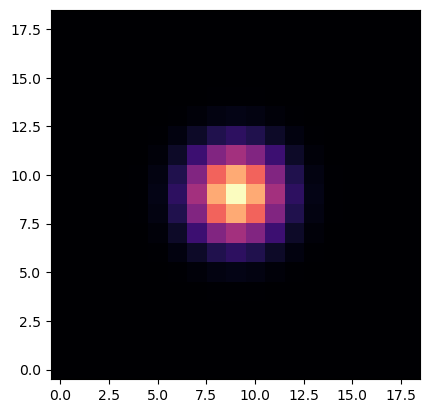

In [6]:
# Compute a Gaussian PSF kernel with given pixel scale, FWHM, and truncation (e.g. 6 * sigma)
kernel = psf.compute_gaussian_kernel(pix_scl, 0.3, 6)
plt.imshow(kernel, cmap='magma')

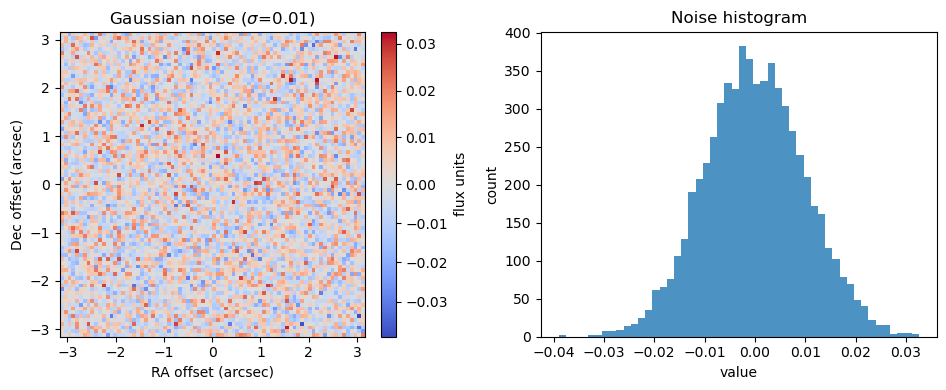

In [7]:
# Visualize background noise map (independent of `hcl.Noise` internals)
rng = np.random.default_rng(0)
noise_map = rng.normal(loc=0.0, scale=background_rms_simu, size=(npix, npix))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
im = ax.imshow(noise_map, origin='lower', cmap='coolwarm', norm=TwoSlopeNorm(0), extent=extent)
ax.set_title(rf"Gaussian noise ($\sigma$={background_rms_simu})")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='flux units')
ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')

ax = axes[1]
ax.hist(noise_map.ravel(), bins=50, color='tab:blue', alpha=0.8)
ax.set_title('Noise histogram')
ax.set_xlabel('value')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()


### Lens galaxy

We assume a SIE simple SIS

In [7]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 1.0 # Einstein radius
y0true = 0.08
y1true = 0.00
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model_true  = hcl.MassModel(["SIE"])
kwargs_lens_true = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]


# Lens light
lens_light_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}
]
#pprint(kwargs_lens_light_input)

# Source light
source_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.1}
]

0.13732309941975984 0.03937676511671417


### Generate the lens image

In [8]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise_simu,
                         lens_mass_model_class=lens_mass_model_true,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_true,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
key = jax.random.PRNGKey(SEED)
key, key_sim = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)

In [9]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

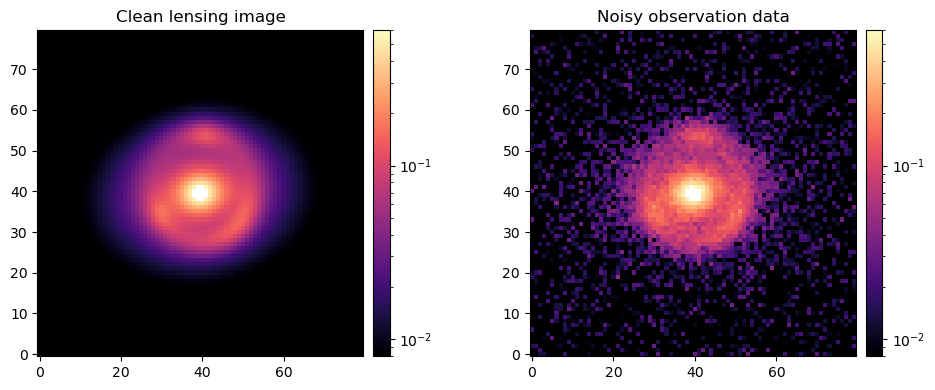

In [10]:
# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

## Set up lens equation solver

In [11]:

#This line creates a pixel grid for the solver with half the original pixel scale (higher resolution)
solver_pixel_grid = pixel_grid.create_model_grid(pixel_scale_factor=0.1)

# Retrieve the pixel coordinates as 2D arrays
solver_grid_x, solver_grid_y = solver_pixel_grid.pixel_coordinates
print(solver_grid_x.shape)

(800, 800)


In [12]:
def ray_shooting_func(theta_x, theta_y, kwargs_lens):
    """Function that computes evaluates the lens equation to return beta = theta - alpha(theta)"""
    beta_x, beta_y = lens_mass_model_true.ray_shooting(theta_x, theta_y, kwargs_lens)
    return beta_x, beta_y

print("Testing ray shooting function:")
print(ray_shooting_func(.08+1.0, 0.0, kwargs_lens_true))

Testing ray shooting function:
(Array(0.13170453, dtype=float64), Array(0.02860362, dtype=float64))


In [13]:
#Set the solver function
solver = LensEquationSolver(solver_grid_x, solver_grid_y, ray_shooting_func)

In [14]:
# Hyperparameters of the solver
solver_params = {
    # You have to specify the number of predicted images in advance
    'nsolutions': 2,

    # Hyperparameters (see docstring above)
    'niter': 4, 
    'scale_factor': 1.5, 
    'nsubdivisions': 6,
}

# T0 KNOW MORE ABOUT THESE PARAMS USE THIS
#?LensEquationSolver.solve

In [15]:
#Based on your the grid resolution, 
#you can obtain a rough estimate of the solver accuracy of the predicted positions in image plane.

estim_acc = solver.estimate_accuracy(
    solver_params['niter'], 
    solver_params['scale_factor'], 
    solver_params['nsubdivisions']
)
print(f"Estimated accuracy in image plane (arcsec): {estim_acc:.2e}")

Estimated accuracy in image plane (arcsec): 1.07e-09


In [16]:
# Set the source position
some_beta_x, some_beta_y = 0.08, 0.00
some_beta = jnp.array([some_beta_x, some_beta_y])  # jnp.array is not absolutely necessary in this notebook

In [17]:
%%time
_ = solver.solve(
    some_beta, kwargs_lens_true, 
    **solver_params
)  # takes some time to JIT-compile

CPU times: user 14.9 s, sys: 2.56 s, total: 17.4 s
Wall time: 23.1 s


In [18]:
# Override solver hyperparameters with finer resolution to avoid grid snapping
solver_params = {
    'nsolutions': 2,
    'niter': 4,
    'scale_factor': 1.5,
    'nsubdivisions': 6,
}
print('Updated solver_params:', solver_params)


Updated solver_params: {'nsolutions': 2, 'niter': 4, 'scale_factor': 1.5, 'nsubdivisions': 6}


In [19]:
some_beta_x_, some_beta_y_ = 0.18, 0.0
some_beta_ = jnp.array([some_beta_x_, some_beta_y_])

In [20]:
%%time
result_thetas, result_betas = solver.solve(
    some_beta_, kwargs_lens_true,
    **solver_params
)  # this is now very fast and differentiable!

CPU times: user 1.83 s, sys: 1.71 s, total: 3.54 s
Wall time: 5.82 s


In [21]:
result_thetas, result_betas

(Array([[-0.76507497, -0.05735348],
        [ 0.9702274 , -0.59899488]], dtype=float64),
 Array([[ 1.80000000e-01,  2.03830316e-10],
        [ 1.80000000e-01, -5.79832478e-13]], dtype=float64))

In [22]:
# Override solver hyperparameters with finer resolution to avoid grid snapping
solver_params = {
    'nsolutions': 2,
    'niter': 4,
    'scale_factor': 1.5,
    'nsubdivisions': 6,
}
print('Updated solver_params:', solver_params)


Updated solver_params: {'nsolutions': 2, 'niter': 4, 'scale_factor': 1.5, 'nsubdivisions': 6}


In [24]:
# Fixed GW likelihood function (JAX-compatible)
def loglike_gw(params, gw_observations):
    """
    GW likelihood function compatible with JAX and prob_model
    
    Parameters:
    -----------
    params : dict
        Dictionary containing lens parameters from prob_model
    gw_observations : dict
        Dictionary containing GW observations:
        - time_delays_true: observed time delays
        - dL_effectives_true: observed effective luminosity distances
        - Tstar: time scale parameter
        - dL: original luminosity distance
        - image_positions: observed image positions [x1, x2, x3, x4]
    """
    # Extract parameters
    Tstar = gw_observations['Tstar']
    dL = gw_observations['dL']
    image_positions = gw_observations['image_positions']  # [x1, x2, x3, x4]
    
    # Extract lens parameters from prob_model
    theta_E = params['lens_theta_E']
    e1 = params['lens_e1']
    e2 = params['lens_e2']
    center_x = params['lens_center_x']
    center_y = params['lens_center_y']
    
    # Define lens model (SIS for simplicity)
    kwargs_lens = [{
        'theta_E': theta_E, 
        'e1': e1, 
        'e2': e2, 
        'center_x': center_x, 
        'center_y': center_y
    }]
    
    # Convert image positions to JAX arrays
    im_coords = jnp.array(image_positions)  # Shape: (4, 2)
    
    # Calculate source position using lens equation
    # For SIS: beta = theta - alpha(theta) where alpha = theta_E * theta/|theta|
    norm = jnp.sqrt(im_coords[:, 0]**2 + im_coords[:, 1]**2)
    alpha_x = theta_E * im_coords[:, 0] / norm
    alpha_y = theta_E * im_coords[:, 1] / norm
    
    # Source position (should be the same for all images)
    beta_x = im_coords[:, 0] - alpha_x
    beta_y = im_coords[:, 1] - alpha_y
    
    # Check consistency (all images should map to same source)
    beta_consistency = jnp.sum((beta_x - beta_x[0])**2 + (beta_y - beta_y[0])**2)
    
    # Calculate Fermat potential and magnification
    fermat_potential = 0.5 * (im_coords[:, 0]**2 + im_coords[:, 1]**2) - theta_E * norm
    magnification = norm / (norm - theta_E)
    
    # Sort by arrival time
    arrival_times = fermat_potential * Tstar
    arrival_order = jnp.argsort(arrival_times)
    
    # Calculate time delays and effective luminosity distances
    time_delays = jnp.diff(arrival_times[arrival_order])
    dL_effectives = dL / jnp.sqrt(jnp.abs(magnification[arrival_order]))
    
    # Likelihood terms
    time_delay_error = 0.05  # 5% error
    dL_effective_error = 0.05  # 5% error
    
    # Time delay likelihood
    time_delay_likelihood = -0.5 * jnp.sum(
        (time_delays - gw_observations['time_delays_true'])**2 / 
        (time_delay_error * gw_observations['time_delays_true'])**2
    )
    
    # Effective luminosity distance likelihood
    dL_likelihood = -0.5 * jnp.sum(
        (dL_effectives - gw_observations['dL_effectives_true'])**2 / 
        (dL_effective_error * gw_observations['dL_effectives_true'])**2
    )
    
    # Source position consistency penalty
    consistency_penalty = -0.5 * beta_consistency / (0.005**2)
    
    return time_delay_likelihood + dL_likelihood + consistency_penalty


In [25]:
# Combined EM + GW ProbModel
class CombinedProbModel(hcl.NumpyroModel):
    
    def __init__(self, gw_observations):
        """
        Initialize combined model with GW observations
        
        Parameters:
        -----------
        gw_observations : dict
            Dictionary containing GW observations
        """
        super().__init__()
        self.gw_observations = gw_observations
    
    def model(self):
        # EM lens parameters (same as before)
        prior_lens = [{
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1)),
            'e1': numpyro.sample('lens_e1', dist.Normal(0.0, 0.005)),
            'e2': numpyro.sample('lens_e2', dist.Normal(0.0, 0.005)),
            'center_x': numpyro.sample('lens_center_x', dist.Normal(0.0, 0.005)),
            'center_y': numpyro.sample('lens_center_y', dist.Normal(0.0, 0.005))
        }]
        
        # Source parameters (same as before)
        prior_source = [{
            'amp': numpyro.sample('source_amp', dist.LogNormal(1.0, 0.1)),
            'R_sersic': numpyro.sample('source_R_sersic', dist.LogNormal(0.2, 0.1)),
            'n_sersic': numpyro.sample('source_n_sersic', dist.Normal(2.0, 0.5)),
            'e1': numpyro.sample('source_e1', dist.Normal(0.05, 0.01)),
            'e2': numpyro.sample('source_e2', dist.Normal(0.05, 0.01)),
            'center_x': numpyro.sample('source_center_x', dist.Normal(0.08, 0.01)),
            'center_y': numpyro.sample('source_center_y', dist.Normal(0.0, 0.01))
        }]
        
        # GW-specific parameters
        Tstar = numpyro.sample('Tstar', dist.LogNormal(0.0, 0.1))  # Time scale
        dL = numpyro.sample('dL', dist.LogNormal(10.0, 0.1))      # Luminosity distance
        
        # Noise parameters
        noise_sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.LogNormal(-4.6, 0.1))
        
        # Combine all parameters
        params = {
            'lens_theta_E': prior_lens[0]['theta_E'],
            'lens_e1': prior_lens[0]['e1'],
            'lens_e2': prior_lens[0]['e2'],
            'lens_center_x': prior_lens[0]['center_x'],
            'lens_center_y': prior_lens[0]['center_y'],
            'source_amp': prior_source[0]['amp'],
            'source_R_sersic': prior_source[0]['R_sersic'],
            'source_n_sersic': prior_source[0]['n_sersic'],
            'source_e1': prior_source[0]['e1'],
            'source_e2': prior_source[0]['e2'],
            'source_center_x': prior_source[0]['center_x'],
            'source_center_y': prior_source[0]['center_y'],
            'Tstar': Tstar,
            'dL': dL,
            'noise_sigma_bkg': noise_sigma_bkg
        }
        
        # EM likelihood
        em_likelihood = self.em_likelihood(params)
        
        # GW likelihood
        gw_likelihood = loglike_gw(params, self.gw_observations)
        
        # Combined likelihood
        total_likelihood = em_likelihood + gw_likelihood
        
        return total_likelihood
    
    def em_likelihood(self, params):
        """Compute EM image likelihood"""
        # This would call your existing EM likelihood function
        # For now, return a placeholder
        return 0.0


In [26]:
# Example usage of combined model
# Define your GW observations
gw_observations = {
    'time_delays_true': jnp.array([0.1, 0.2, 0.15]),  # Observed time delays
    'dL_effectives_true': jnp.array([1000.0, 1200.0, 1100.0, 1300.0]),  # Observed effective dL
    'Tstar': 1.0,  # Time scale parameter
    'dL': 1000.0,  # Original luminosity distance
    'image_positions': jnp.array([
        [1.2, 0.0],   # Image 1
        [-0.8, 0.0],  # Image 2
        [0.0, 1.1],   # Image 3
        [0.0, -0.9]   # Image 4
    ])
}

# Create combined model
combined_model = CombinedProbModel(gw_observations)

# Create loss function
combined_loss = hcl.Loss(combined_model)

print("Combined model created successfully!")
print("Parameters:", combined_model.get_parameter_names())


Combined model created successfully!


AttributeError: 'CombinedProbModel' object has no attribute 'get_parameter_names'

In [27]:
def solve_sis(y0,y1):
    theta = jnp.arctan(y1/y0)
    im1 = jnp.array([y0,y1]) + 1*jnp.array([jnp.cos(theta),jnp.sin(theta)])
    im2 = jnp.array([y0,y1]) - 1*jnp.array([jnp.cos(theta),jnp.sin(theta)])
    im_coords = jnp.array([im1,im2])
    return im_coords
    

In [26]:
betax = jnp.array([0.08,0.08,0.08])
betay = jnp.array([0,0,0])
solve_sis(betax, betay)

Array([[[ 1.08,  1.08,  1.08],
        [ 0.  ,  0.  ,  0.  ]],

       [[-0.92, -0.92, -0.92],
        [ 0.  ,  0.  ,  0.  ]]], dtype=float64)

In [28]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = hcl.LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model_true),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)

In [ ]:
class ProbModel(hcl.NumpyroModel):
    
    def model(self):
        # Parameters of the source
        prior_source = [
          {
              'amp': numpyro.sample('source_amp', dist.LogNormal(1.0, 0.1)),
         'R_sersic': numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.2, 0.1, low=0.05)), 
         'n_sersic': numpyro.sample('source_n', dist.Uniform(1., 3.)), 
         'e1': numpyro.sample('source_e1', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('source_e2', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('source_center_x', dist.Normal(0.05, 0.02)), 
        'center_y': numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))}
        ]

        # Parameters of the lens light that are used for the lens mass
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))

        # Parameters of the lens light, with center relative the lens mass
        prior_lens_light = [
        {'amp': numpyro.sample('light_amp', dist.LogNormal(2., 0.1)), 
         'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.1)), 
         'n_sersic': numpyro.sample('light_n', dist.Uniform(2., 5.)), 
         'e1': e1,
         'e2': e2,
         'center_x': cx, 
         'center_y': cy}
        ]

        prior_lens = [
        # power-law
        {
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1)),
         'e1': numpyro.sample('lens_e1', dist.Normal(e1, 0.005)),
         'e2': numpyro.sample('lens_e2', dist.Normal(e2, 0.005)),
         'center_x': numpyro.sample('lens_center_x', dist.Normal(cx, 0.005)), 
         'center_y': numpyro.sample('lens_center_y', dist.Normal(cy, 0.005))},
        # # external shear, with fixed origin
        # {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
        #  'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
        #  'ra_0': 0.0, 'dec_0': 0.0}
        ]
        print(prior_lens)
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
        model_var = noise.C_D_model(model_image, background_rms=sigma_bkg)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flatten dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        # {'gamma1': params['lens_gamma1'],
        # 'gamma2': params['lens_gamma2'],
        # 'ra_0': 0.0,
        # 'dec_0': 0.0}
        ],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}]}
        return kw

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


[{'theta_E': Array(1.53563324, dtype=float64), 'e1': Array(0.05144639, dtype=float64), 'e2': Array(0.11663407, dtype=float64), 'center_x': Array(-0.01550962, dtype=float64), 'center_y': Array(-0.01998712, dtype=float64)}]
Number of parameters: 20


[{'theta_E': Array(1.317514, dtype=float64), 'e1': Array(0.0406196, dtype=float64), 'e2': Array(0.01314686, dtype=float64), 'center_x': Array(0.04426212, dtype=float64), 'center_y': Array(-0.00722165, dtype=float64)}]
{'source_amp': Array(3.32277036, dtype=float64), 'source_R_sersic': Array(0.06034447, dtype=float64), 'source_n': Array(1.95294744, dtype=float64), 'source_e1': Array(0.04090416, dtype=float64), 'source_e2': Array(-0.07979644, dtype=float64), 'source_center_x': Array(0.03691132, dtype=float64), 'source_center_y': Array(0.15775192, dtype=float64), 'light_center_x': Array(0.02949153, dtype=float64), 'light_center_y': Array(-0.01221115, dtype=float64), 'light_e1': Array(0.03974113, dtype=float64), 'light_e2': Array(0.01799019, dtype=float64), 'light_amp': Array(7.9481264, dtype=float64), 'light_R_sersic': Array(0.99137183, dtype=float64), 'light_n': Array(4.35724066, dtype=float64), 'lens_theta_E': Array(1.317514, dtype=float64), 'lens_e1': Array(0.0406196, dtype=float64), '

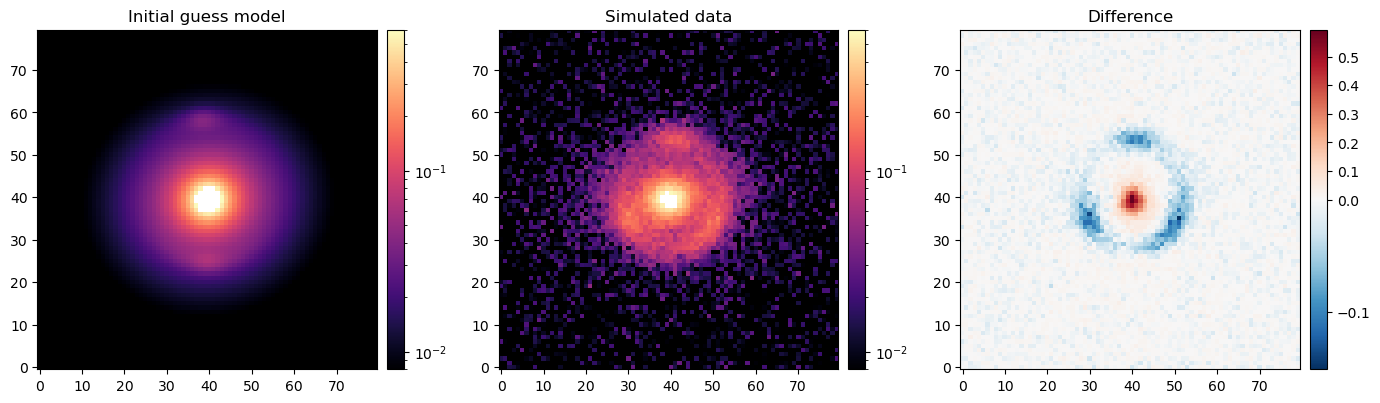

In [29]:
# visualize initial guess
key, key_init = jax.random.split(key)
init_params = prob_model.get_sample(key_init)  # constrained space
print(init_params)
init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
print(init_params_unconst)
kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

## Create GW observables

In [36]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import astropy.constants as const
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import param_util

In [34]:
def get_time_delay_distance(z_lens, z_source, cosmo = cosmo):
    ''' Returns the time delay distance in Mpc between a lens at redshift z_lens and a source at redshift z_source '''
    Dds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
    Ds = cosmo.angular_diameter_distance(z_source)
    Dd = cosmo.angular_diameter_distance(z_lens)
    D_dt = (1+z_lens)*Ds*Dd/Dds
    return D_dt # In units of Mpc

arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 


In [37]:

#use lenstronomy solver to get exact image positions
# compute image position of full model (with numerical options attached)
x_image, y_image = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_true, sourcePos_x=y0true, sourcePos_y=y1true, min_distance=0.01, search_window=5, precision_limit=10**(-10), num_iter_max=100)
print('image positions: ', x_image)
# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image, y_image, kwargs_lens_list)
print("the relative precision of the image positions are: ", x_source_new - x_source)

NameError: name 'lensEquationSolver' is not defined

### Define the loss function

This class is essentially calling the `log_prob` of the probabilistic model defined above, but adds a simple interface to get the gradient and hessian of the loss function.

In [30]:
loss = hcl.Loss(prob_model)
print("Initial loss =", loss(init_params_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

[{'theta_E': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e1': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e2': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_x': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_y': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>}]
Initial loss = -9892.688958999674


### Set the optimizer to minimize the loss function

In [31]:
optimizer = hcl.JaxoptOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
print("Runtime:", runtime)

[{'theta_E': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e1': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e2': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_x': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_y': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>}]
Runtime: 25.51773715019226


Final loss = -19305.97017230707


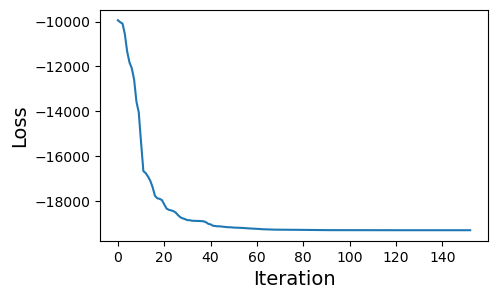

In [32]:
print("Final loss =", loss(best_fit))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()

[{'theta_E': Array(0.99593227, dtype=float64), 'e1': Array(-0.01180878, dtype=float64), 'e2': Array(-0.00341813, dtype=float64), 'center_x': Array(0.03519808, dtype=float64), 'center_y': Array(0.07756763, dtype=float64)}]


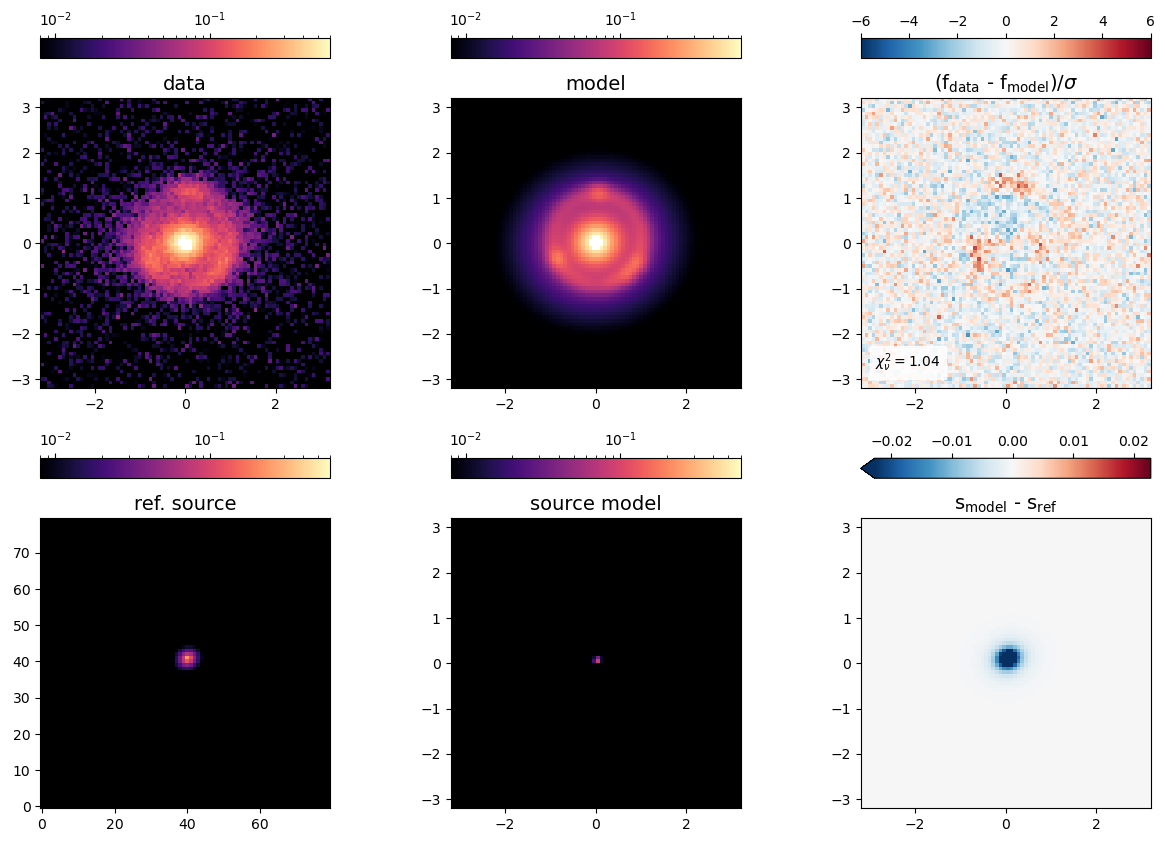

In [33]:
# the best-fit values are in unconstrained space so we transform them here
best_fit_constrained = prob_model.constrain(best_fit)
kwargs_best_fit = prob_model.params2kwargs(best_fit_constrained)

fig = plotter.model_summary(lens_image, 
                            kwargs_best_fit, 
                            kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
                            show_source=True)
plt.show()

In [34]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_best_fit)

print("="*80)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': Array(0.03519808, dtype=float64),
                  'center_y': Array(0.07756763, dtype=float64),
                  'e1': Array(-0.01180878, dtype=float64),
                  'e2': Array(-0.00341813, dtype=float64),
                  'theta_E': Array(0.99593227, dtype=float64)}],
 'kwargs_lens_light': [{'R_sersic': Array(0.96993612, dtype=float64),
                        'amp': Array(7.79608393, dtype=float64),
                        'center_x': Array(0.00715123, dtype=float64),
                        'center_y': Array(0.00571494, dtype=float64),
                        'e1': Array(0.0440813, dtype=float64),
                        'e2': Array(0.01804814, dtype=float64),
                        'n_sersic': Array(2.84749938, dtype=float64)}],
 'kwargs_source': [{'R_sersic': Array(0.07209414, dtype=float64),
                    'amp': Array(3.36257019, dtype=float64),
                    'center_x': Array(0.03189691, dtype=float64),
     

In [35]:
@jax.jit
def loss_constrained(params_const):
    params_unconst = prob_model.unconstrain(params_const)
    return loss(params_unconst)

@jax.jit
def hessian_constrained(params_const):
    return jax.jacfwd(jax.jacrev(loss_constrained))(params_const)

fisher_matrix = hessian_constrained(prob_model.constrain(best_fit))  # pytree
fisher_matrix, _ = jax.flatten_util.ravel_pytree(fisher_matrix)  # get the array
fisher_matrix = fisher_matrix.reshape((20, 20))  # reshape as a matrix
cov_matrix = jnp.linalg.inv(fisher_matrix) # invert to get covariance matrix

[{'theta_E': Array(0.99593227, dtype=float64), 'e1': Array(-0.01180878, dtype=float64), 'e2': Array(-0.00341813, dtype=float64), 'center_x': Array(0.03519808, dtype=float64), 'center_y': Array(0.07756763, dtype=float64)}]
[{'theta_E': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e1': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'e2': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_x': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>, 'center_y': Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>}]


In [36]:
mean, unravel_fn = jax.flatten_util.ravel_pytree(prob_model.constrain(best_fit))
cov = cov_matrix
fim_samples = jax.vmap(unravel_fn)(np.random.multivariate_normal(mean, cov, size=3000))
#print(fim_samples)

[{'theta_E': Array(0.99593227, dtype=float64), 'e1': Array(-0.01180878, dtype=float64), 'e2': Array(-0.00341813, dtype=float64), 'center_x': Array(0.03519808, dtype=float64), 'center_y': Array(0.07756763, dtype=float64)}]


In [37]:
@jax.jit
def logdensity_fn(args):
    return -loss(args)

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
    progress_bar=True, 
)

num_steps_adaptation = 100

key, key_hmc_adapt, key_hmc_run = jax.random.split(key, 3)

start = time.time()
(last_state, adapted_settings), info = adapt.run(key_hmc_adapt, best_fit, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

Running window adaptation
Time taken by HMC (blackjax) warmup phase: 28.018843173980713
Warmup state (lens only, unconstrained) 

{'lens_center_x': Array(0.03525264, dtype=float64), 'lens_center_y': Array(0.0773725, dtype=float64), 'lens_e1': Array(-0.01125199, dtype=float64), 'lens_e2': Array(-0.00357927, dtype=float64), 'lens_theta_E': Array(0.99605505, dtype=float64)}


In [38]:
best_fit.keys()

dict_keys(['lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_theta_E', 'light_R_sersic', 'light_amp', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_n', 'noise_sigma_bkg', 'source_R_sersic', 'source_amp', 'source_center_x', 'source_center_y', 'source_e1', 'source_e2', 'source_n'])

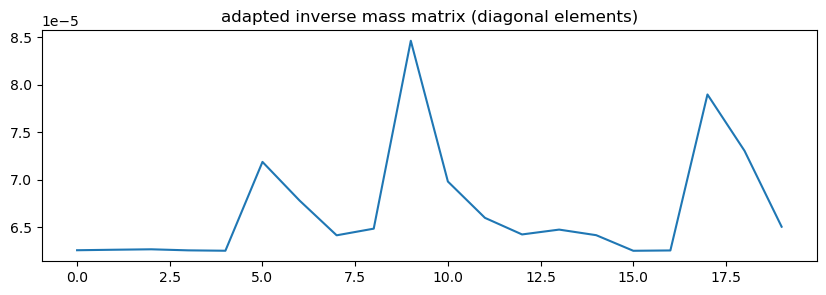

In [39]:
# visualize the inverse mass matrix we will use for HMC

plt.figure(figsize=(10, 3))
plt.title("adapted inverse mass matrix (diagonal elements)")
plt.plot(adapted_settings['inverse_mass_matrix'])
plt.show()

In [ ]:
# setup the NUTS kernel with adapted settings
kernel = blackjax.nuts(logdensity_fn, **adapted_settings).step

# define the inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

num_steps_nuts = 3_000 # number of samples

start = time.time()
states, infos = inference_loop(key_hmc_run, kernel, last_state, num_steps_nuts)
_ = states.position['lens_theta_E'].block_until_ready()
print("Time taken by HMC (blackjax) main phase:", time.time()-start) 

In [ ]:
def loglike_im(u):
    Tstar, dL, x10, x20 = u
    x11 = 0
    x21 = 0
    #DEFINE THE DIMENSIONLESS SYSTEM, SET THETA_E = 1
    cx0_ = 0.0
    cy0_ = 0.0
    q=1
    e1_, e2_ = 0,0#param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q) # conversion to ellipticities
    #print(e1_,e2_)
    kwargs_lens_= [
    {'theta_E': 1.0, 'e1': e1_, 'e2': e2_, 
     'center_x': cx0_, 'center_y': cy0_}]
    
    im_coords = np.array([jnp.array([x10,x11]), np.array([x20,x21])])
    norm = np.sqrt(im_coords[:,0]**2 + im_coords[:,1]**2)

    
    y = np.array([im_coords[:,0], im_coords[:,1]]) - np.asarray([im_coords[:,0]/norm,im_coords[:,1]/norm])
    y = y.T
    # print('y1:', y[0])
    # print('y2:', y[1])
    snorm1 = np.sqrt(np.sum(y[0]**2))
    snorm1 = np.sqrt(np.sum(y[1]**2))
    # if snorm1 >=1 or snorm_tr2>=0:
    #     return -np.inf
    
    fermat_potential_ = (1/2) - norm#jnp.sqrt(im_coords[:,0]**2 + im_coords[:,1]**2)
    mu_ = norm/(norm-1)
    
    #GW lensing observables
    tarrivals = fermat_potential_*Tstar
    arrival_id = np.argsort(tarrivals)
    tarrivals_sorted = tarrivals[arrival_id]
    time_delays = np.diff(tarrivals_sorted)

    mu_sorted = mu_[arrival_id]
    dL_effectives = dL/np.sqrt(jnp.abs(mu_sorted))
    
    sigma_td = time_delays_true * 0.05
    sigma_dL_eff = dL_effectives_true * 0.05

    yerror = 0.005
    ylhd_12 = (np.sum((y[1] - y[0])**2))/(yerror**2)
    # print('_'*50)
    return -0.5 * (np.sum((time_delays - time_delays_true)**2/sigma_td**2) 
                    + np.sum((dL_effectives - dL_effectives_true)**2/sigma_dL_eff**2) + ylhd_12) 
    

In [ ]:
def joint_loglike(lens_params, image_data, gw_data):
    """Compute joint log-likelihood for image and GW data, sharing lens parameters."""
    # 1. Image likelihood (pixel-wise Gaussian)
    model_image = lens_image.model(**lens_params)
    model_std = noise.C_D_model(model_image, background_rms=lens_params.get('noise_sigma_bkg', 1e-2))
    loglike_image = -0.5 * np.sum((image_data - model_image)**2 / model_std**2)
    
    # 2. GW likelihood (using your loglike_im function)
    gw_lens_params = gw_data['gw_lens_params']  # e.g., [Tstar, dL, x10, x20]
    loglike_gw = loglike_im(gw_lens_params)
    
    # 3. Combine
    return loglike_image + loglike_gw